In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.linear_model import LogisticRegression

# Load banking dataset
data = pd.read_csv('bank.csv', delimiter=';')

# Assume the target variable is whether a person will deposit or not (binary: 'yes' for deposit, 'no' for no deposit)
# For simplicity, we focus on 'age', 'balance', and the target variable 'deposit'.
data = data[['age', 'balance', 'y']]

# Select few-shot samples for synthetic generation ensuring both classes are represented
def sample_few_shot(data, n=10):
    # Select samples ensuring at least one of each class is present
    sampled_data = data.groupby('y').apply(lambda x: x.sample(min(len(x), n//2))).reset_index(drop=True)
    return sampled_data

few_shot_data = sample_few_shot(data)

# Add Differential Privacy (DP) noise using Laplace mechanism
def add_dp_noise(data, epsilon, sensitivity=1.0):
    noise = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=data.shape)
    return data + noise

# Generate noisy synthetic few-shot data to use as ICL prompts
epsilon = 1.0  # Privacy budget
synthetic_few_shot = add_dp_noise(few_shot_data[['age', 'balance']].to_numpy(), epsilon)

# Convert synthetic data to DataFrame for structured output
synthetic_few_shot_df = pd.DataFrame(synthetic_few_shot, columns=['age', 'balance'])

# Print the original few-shot samples and the noisy DP-protected samples (ICL prompts)
print("Original Few-Shot Examples (Before DP Noise):")
print(few_shot_data)
print("\nDifferentially Private Few-Shot Prompts (ICL Prompts):")
print(synthetic_few_shot_df)

# Convert original few-shot data for model training
X_few_shot = few_shot_data[['age', 'balance']]
y_few_shot = few_shot_data['y'].replace({'no': 0, 'yes': 1})  # Convert to binary

# Train a Logistic Regression model on original few-shot data
model = LogisticRegression()
model.fit(X_few_shot, y_few_shot)

# Prepare synthetic few-shot data for model inference (ICL prompts)
X_synthetic = synthetic_few_shot_df

# New input for inference (this would be the new data the model is predicting on)
new_input = pd.DataFrame([[35, 500]], columns=['age', 'balance'])

# Show the new input for inference
print("\nNew input for inference: ")
print(new_input)

# Make prediction with original few-shot examples as context
# Here we concatenate new input with synthetic few-shot prompts for ICL
combined_input = pd.concat([X_synthetic, new_input], ignore_index=True)

# Predicting with the original model using ICL prompts
predictions_with_dp = model.predict(combined_input)

# The last prediction corresponds to the new input
new_input_prediction_with_dp = predictions_with_dp[-1]

# Show the predictions for the original few-shot examples and the new input
print("\nPredictions with Differentially Private Few-Shot Prompts:")
for idx, pred in enumerate(predictions_with_dp[:-1]):  # Exclude new input prediction
    print(f"Input (Age: {synthetic_few_shot_df.iloc[idx]['age']}, Balance: {synthetic_few_shot_df.iloc[idx]['balance']}), Prediction: {'Will Deposit' if pred == 1 else 'Will Not Deposit'}")

print(f"\nPrediction for New Input (Age: {new_input['age'][0]}, Balance: {new_input['balance'][0]}): {'Will Deposit' if new_input_prediction_with_dp == 1 else 'Will Not Deposit'}")


Original Few-Shot Examples (Before DP Noise):
   age  balance    y
0   54      136   no
1   42     -416   no
2   36      510   no
3   33     1909   no
4   33      166   no
5   45     2552  yes
6   63     1795  yes
7   40     4775  yes
8   30     7529  yes
9   43     4333  yes

Differentially Private Few-Shot Prompts (ICL Prompts):
         age      balance
0  54.786633   136.310488
1  42.326043  -417.133599
2  38.583143   510.160174
3  31.276481  1909.356446
4  31.245850   168.186674
5  44.972790  2554.268049
6  61.894523  1795.866517
7  39.833485  4774.959631
8  29.650718  7527.775029
9  45.093585  4332.350905

New input for inference: 
   age  balance
0   35      500

Predictions with Differentially Private Few-Shot Prompts:
Input (Age: 54.786632821752775, Balance: 136.31048841313822), Prediction: Will Not Deposit
Input (Age: 42.32604254834693, Balance: -417.13359856031093), Prediction: Will Not Deposit
Input (Age: 38.583143115877824, Balance: 510.16017407253213), Prediction: Will No

<ipython-input-1-d5543f3302a9>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('y').apply(lambda x: x.sample(min(len(x), n//2))).reset_index(drop=True)
<ipython-input-1-d5543f3302a9>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_few_shot = few_shot_data['y'].replace({'no': 0, 'yes': 1})  # Convert to binary



Total Predictions: 10
Correct Predictions: 10
Accuracy with Differentially Private Few-Shot Prompts: 1.00


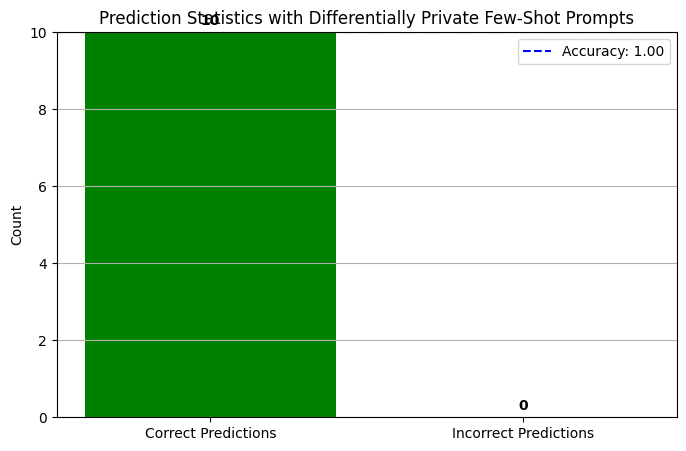

In [ ]:
import matplotlib.pyplot as plt

# Calculate the accuracy of the predictions
correct_predictions = (predictions_with_dp[:-1] == y_few_shot.to_numpy()).sum()
total_predictions = len(predictions_with_dp) - 1  # Excluding the new input

# Accuracy
accuracy = correct_predictions / total_predictions

# Print statistics
print(f"\nTotal Predictions: {total_predictions}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Accuracy with Differentially Private Few-Shot Prompts: {accuracy:.2f}")

# Prepare data for plotting
labels = ['Correct Predictions', 'Incorrect Predictions']
values = [correct_predictions, total_predictions - correct_predictions]

# Plotting the statistics
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['green', 'red'])
plt.title('Prediction Statistics with Differentially Private Few-Shot Prompts')
plt.ylabel('Count')
plt.ylim(0, total_predictions)
plt.grid(axis='y')

# Show the accuracy on the plot
for i, v in enumerate(values):
    plt.text(i, v + 0.2, str(v), ha='center', fontweight='bold')

plt.axhline(y=accuracy * total_predictions, color='blue', linestyle='--', label=f'Accuracy: {accuracy:.2f}')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Load banking dataset
data = pd.read_csv('bank.csv', delimiter=';')

# Assume the target variable is whether a person will deposit or not (binary: 'yes' for deposit, 'no' for no deposit)
# For simplicity, we focus on 'age', 'balance', and the target variable 'y'.
data = data[['age', 'balance', 'y']]

# Select few-shot samples for synthetic generation ensuring both classes are represented
def sample_few_shot(data, n=10):
    # Select samples ensuring at least one of each class is present
    sampled_data = data.groupby('y').apply(lambda x: x.sample(min(len(x), n//2))).reset_index(drop=True)
    return sampled_data

few_shot_data = sample_few_shot(data)

# Add Differential Privacy (DP) noise using Laplace mechanism
def add_dp_noise(data, epsilon, sensitivity=1.0):
    noise = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=data.shape)
    return data + noise

# Convert original few-shot data for model training
X_few_shot = few_shot_data[['age', 'balance']]
y_few_shot = few_shot_data['y'].replace({'no': 0, 'yes': 1})  # Convert to binary

# Store results for different epsilon values
epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0]
accuracies = []

for epsilon in epsilon_values:
    # Generate noisy synthetic few-shot data to use as ICL prompts
    synthetic_few_shot = add_dp_noise(few_shot_data[['age', 'balance']].to_numpy(), epsilon)

    # Convert synthetic data to DataFrame for structured output
    synthetic_few_shot_df = pd.DataFrame(synthetic_few_shot, columns=['age', 'balance'])

    # Train a Logistic Regression model on original few-shot data
    model = LogisticRegression()
    model.fit(X_few_shot, y_few_shot)

    # Prepare synthetic few-shot data for model inference (ICL prompts)
    X_synthetic = synthetic_few_shot_df

    # New input for inference (this would be the new data the model is predicting on)
    new_input = pd.DataFrame([[35, 500]], columns=['age', 'balance'])

    # Make prediction with original few-shot examples as context
    combined_input = pd.concat([X_synthetic, new_input], ignore_index=True)

    # Predicting with the original model using ICL prompts
    predictions_with_dp = model.predict(combined_input)

    # The last prediction corresponds to the new input
    new_input_prediction_with_dp = predictions_with_dp[-1]

    # Calculate accuracy of predictions
    correct_predictions = np.sum(predictions_with_dp[:-1] == y_few_shot.to_numpy())
    total_predictions = len(predictions_with_dp[:-1])
    accuracy = correct_predictions / total_predictions * 100

    # Store accuracy
    accuracies.append(accuracy)

# Print accuracy results for each epsilon
for eps, acc in zip(epsilon_values, accuracies):
    print(f"Accuracy with epsilon={eps}: {acc:.2f}%")

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(epsilon_values, accuracies, marker='o')
plt.xticks(epsilon_values)
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs. Epsilon Values')
plt.grid()
plt.show()


**Shiv's Code**

<ipython-input-5-8a77fb80a0ce>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('y').apply(lambda x: x.sample(min(len(x), n//2))).reset_index(drop=True)
<ipython-input-5-8a77fb80a0ce>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_few_shot = few_shot_data['y'].replace({'no': 0, 'yes': 1})
<ipython-input-5-8a77fb80a0ce>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain 

   epsilon  accuracy
0      0.1      70.0
1      0.5      70.0
2      1.0      40.0
3      2.0      40.0
4      5.0      60.0


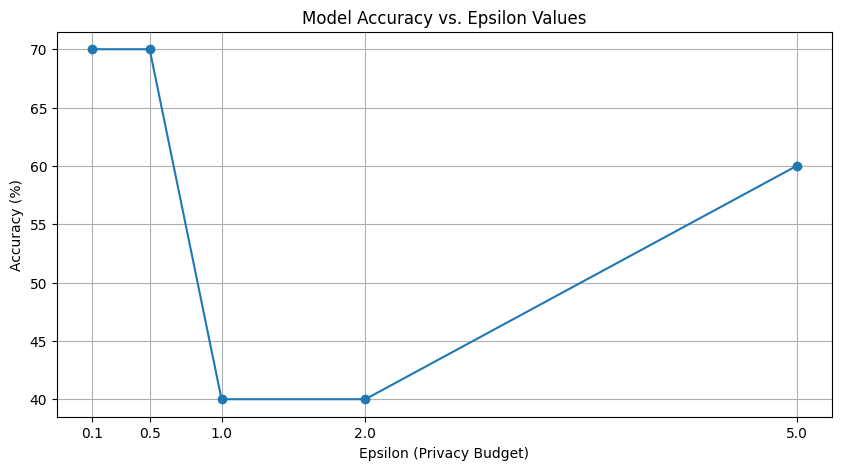

In [ ]:
# prompt: Synthetic data generation implement Procedural Generation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Load banking dataset (replace 'bank.csv' with your actual file path)
try:
    data = pd.read_csv('bank.csv', delimiter=';')
except FileNotFoundError:
    print("Error: 'bank.csv' not found. Please upload the dataset to the Colab environment or provide the correct path.")
    exit()

# Data preprocessing (same as before)
data = data[['age', 'balance', 'y']]

def sample_few_shot(data, n=10):
    sampled_data = data.groupby('y').apply(lambda x: x.sample(min(len(x), n//2))).reset_index(drop=True)
    return sampled_data

few_shot_data = sample_few_shot(data)

def add_dp_noise(data, epsilon, sensitivity=1.0):
    noise = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=data.shape)
    return data + noise

# Procedural generation with different epsilon values
epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []

for epsilon in epsilon_values:
    synthetic_few_shot = add_dp_noise(few_shot_data[['age', 'balance']].to_numpy(), epsilon)
    synthetic_few_shot_df = pd.DataFrame(synthetic_few_shot, columns=['age', 'balance'])

    X_few_shot = few_shot_data[['age', 'balance']]
    y_few_shot = few_shot_data['y'].replace({'no': 0, 'yes': 1})
    model = LogisticRegression()
    model.fit(X_few_shot, y_few_shot)

    X_synthetic = synthetic_few_shot_df
    new_input = pd.DataFrame([[35, 500]], columns=['age', 'balance'])
    combined_input = pd.concat([X_synthetic, new_input], ignore_index=True)
    predictions_with_dp = model.predict(combined_input)

    correct_predictions = np.sum(predictions_with_dp[:-1] == y_few_shot.to_numpy())
    total_predictions = len(predictions_with_dp[:-1])
    accuracy = correct_predictions / total_predictions * 100
    results.append({'epsilon': epsilon, 'accuracy': accuracy})

results_df = pd.DataFrame(results)
print(results_df)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(results_df['epsilon'], results_df['accuracy'], marker='o')
plt.xticks(epsilon_values)
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs. Epsilon Values')
plt.grid()
plt.show()

**Neha's Code**


**Withot GPT or LLM models**

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load banking dataset
data = pd.read_csv('bank.csv', delimiter=';')

# Preprocess data for privacy-preserving tasks
data = data[['age', 'balance', 'y']]  # Assuming 'y' is the target column (yes/no deposit)

# Function to sample data for few-shot learning
def sample_few_shot(data, n=10):
    sampled_data = data.groupby('y').apply(lambda x: x.sample(min(len(x), n//2))).reset_index(drop=True)
    return sampled_data

few_shot_data = sample_few_shot(data)

# Function to add Differential Privacy (DP) noise using Laplace mechanism
def add_dp_noise(data, epsilon, sensitivity=1.0):
    if epsilon == 0:
        raise ValueError("Epsilon cannot be zero for Differential Privacy noise addition.")
    noise = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=data.shape)
    return data + noise

# Generate noisy synthetic few-shot data (ICL prompts)
epsilon = 1.0  # Privacy budget
synthetic_few_shot = add_dp_noise(few_shot_data[['age', 'balance']].to_numpy(), epsilon)

# Convert synthetic data to DataFrame for structured output
synthetic_few_shot_df = pd.DataFrame(synthetic_few_shot, columns=['age', 'balance'])

# Print the original few-shot samples and noisy DP-protected samples
print("Original Few-Shot Examples (Before DP Noise):")
print(few_shot_data)
print("\nDifferentially Private Few-Shot Prompts (ICL Prompts):")
print(synthetic_few_shot_df)

# Model training with original few-shot data
X_few_shot = few_shot_data[['age', 'balance']]
y_few_shot = few_shot_data['y'].replace({'no': 0, 'yes': 1})  # Convert to binary

model = LogisticRegression()
model.fit(X_few_shot, y_few_shot)

# Prepare synthetic data for model inference
X_synthetic = synthetic_few_shot_df

# New input for prediction
new_input = pd.DataFrame([[35, 500]], columns=['age', 'balance'])

print("\nNew input for inference: ")
print(new_input)

# Combine synthetic few-shot data with new input for ICL (In-Context Learning)
combined_input = pd.concat([X_synthetic, new_input], ignore_index=True)

# Predict with the original model using ICL
predictions_with_dp = model.predict(combined_input)

# The last prediction corresponds to the new input
new_input_prediction_with_dp = predictions_with_dp[-1]

print("\nPredictions with Differentially Private Few-Shot Prompts:")
for idx, pred in enumerate(predictions_with_dp[:-1]):
    print(f"Input (Age: {synthetic_few_shot_df.iloc[idx]['age']}, Balance: {synthetic_few_shot_df.iloc[idx]['balance']}), Prediction: {'Will Deposit' if pred == 1 else 'Will Not Deposit'}")

print(f"\nPrediction for New Input (Age: {new_input['age'][0]}, Balance: {new_input['balance'][0]}): {'Will Deposit' if new_input_prediction_with_dp == 1 else 'Will Not Deposit'}")

# Now implement private aggregation (e.g., using Gaussian or Report-Noisy-Max)
def private_aggregation(probs, epsilon, mechanism='Gaussian'):
    if mechanism == 'Gaussian':
        noise = np.random.normal(0, 1/epsilon, size=probs.shape)
        return np.clip(probs + noise, 0, 1)  # Ensure probabilities are between 0 and 1
    elif mechanism == 'Report-Noisy-Max':
        noisy_probs = np.random.exponential(probs / epsilon)
        return np.argmax(noisy_probs)  # Report the noisy max

# Example of applying private aggregation to the model's predictions
private_probs = model.predict_proba(combined_input)[:, 1]  # Get probabilities for class '1' (Will Deposit)
private_probs_aggregated = private_aggregation(private_probs, epsilon, mechanism='Gaussian')

# Display results of private aggregation
print("\nPrivate Aggregated Prediction:")
print(f"Predicted Probability of Deposit (after DP aggregation): {private_probs_aggregated[-1]:.4f}")
print(f"Prediction (Private Aggregated): {'Will Deposit' if private_probs_aggregated[-1] >= 0.5 else 'Will Not Deposit'}")

# Evaluate accuracy for various epsilon values
def evaluate_model_with_epsilon(epsilon):
    if epsilon == 0:
        # Perform evaluation without adding DP noise (no privacy noise)
        synthetic_data = few_shot_data[['age', 'balance']].to_numpy()  # No DP noise
    else:
        synthetic_data = add_dp_noise(few_shot_data[['age', 'balance']], epsilon)

    # Train model with synthetic data (use the original labels)
    model = LogisticRegression()
    X_few_shot = synthetic_data
    y_few_shot = few_shot_data['y'].replace({'no': 0, 'yes': 1})  # Convert to binary
    model.fit(X_few_shot, y_few_shot)

    # Evaluate the model on synthetic data
    y_pred = model.predict(X_few_shot)  # Ensure y_pred is an array of predictions

    # Calculate accuracy using accuracy_score
    accuracy = accuracy_score(y_few_shot, y_pred)

    return accuracy

# Evaluate with different epsilon values
epsilons = [1, 2, 4, 8, 10]
accuracies = [evaluate_model_with_epsilon(epsilon) for epsilon in epsilons]

# Display results in a table or print them
print("Accuracies for different epsilon values:")
for epsilon, accuracy in zip(epsilons, accuracies):
    print(f"Epsilon = {epsilon}: Accuracy = {accuracy:.2f}")


Original Few-Shot Examples (Before DP Noise):
   age  balance    y
0   38     -220   no
1   30     1622   no
2   34     4962   no
3   30      705   no
4   38     1852   no
5   35      611  yes
6   30      617  yes
7   51      825  yes
8   21      123  yes
9   26      390  yes

Differentially Private Few-Shot Prompts (ICL Prompts):
         age      balance
0  38.438941  -220.311346
1  28.998765  1621.079204
2  34.501251  4959.368077
3  26.047923   707.125861
4  37.364537  1852.107003
5  33.363777   610.204520
6  27.178682   615.115472
7  51.128363   824.937502
8  21.370483   122.468715
9  25.988559   392.339408

New input for inference: 
   age  balance
0   35      500

Predictions with Differentially Private Few-Shot Prompts:
Input (Age: 38.43894129741635, Balance: -220.31134570767333), Prediction: Will Deposit
Input (Age: 28.998765216727925, Balance: 1621.079203929442), Prediction: Will Not Deposit
Input (Age: 34.50125125453475, Balance: 4959.368076579855), Prediction: Will Not Depos

<ipython-input-19-9972b1094d9b>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('y').apply(lambda x: x.sample(min(len(x), n//2))).reset_index(drop=True)
<ipython-input-19-9972b1094d9b>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_few_shot = few_shot_data['y'].replace({'no': 0, 'yes': 1})  # Convert to binary
<ipython-input-19-9972b1094d9b>:100: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a f

With

In [ ]:
pip install huggingface_hub


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load and preprocess data
data = pd.read_csv('bank.csv', delimiter=';')
data = data.dropna(subset=['age', 'balance', 'y'])  # Drop rows with NaNs

# Separate features and target
X = data[['age', 'balance']]
y = data['y']

# Perform oversampling with SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print the shapes of the original and resampled datasets
from collections import Counter
print(f"Original dataset shape: {Counter(y)}")
print(f"Resampled dataset shape: {Counter(y_resampled)}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

train_data = pd.DataFrame(X_train, columns=['age', 'balance'])
train_data['y'] = y_train

test_data = pd.DataFrame(X_test, columns=['age', 'balance'])
test_data['y'] = y_test

# Function to add noise for differential privacy
def add_noise(predictions, epsilon):
    if epsilon == 0.0:
        return predictions
    noise = np.random.normal(scale=1/epsilon, size=len(predictions))
    noisy_predictions = np.clip(predictions + noise, 0, 1)  # Keep predictions between 0 and 1
    return (noisy_predictions > 0.5).astype(int)  # Convert to binary labels

# Function to generate few-shot prompts
def generate_few_shot_prompts(data, shots):
    prompts = []
    sampled_data = data.sample(n=shots, random_state=42)
    for _, row in sampled_data.iterrows():
        prompts.append(
            f"If a person is {row['age']} years old and has a balance of {row['balance']}, will they subscribe to a term deposit? Answer: {'yes' if row['y'] == 1 else 'no'}."
        )
    return prompts

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model and tokenizer (DistilBERT)
model_name = "distilbert-base-uncased"  # DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Function to query LLM for prediction
def query_llm(few_shot_examples, query):
    input_prompt = "\n".join(few_shot_examples) + f"\n\n{query} Answer:"
    inputs = tokenizer(input_prompt, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()
    return predictions[0]

# Evaluate model for different shots and epsilon values
results = []

shots_list = [2, 4, 10, 20]
epsilon_list = [0.0, 0.1, 0_.5]
queries = [
    "If a person is 30 years old and has a balance of 1000, will they subscribe to a term deposit?",
    "If a person is 45 years old and has a balance of 1500, will they subscribe to a term deposit?",
]

# Iterate over different shots and epsilon values
for shots in shots_list:
    few_shot_examples = generate_few_shot_prompts(train_data, shots)
    predictions = []

    for query in queries:
        # Query the model and predict based on the response
        prediction = query_llm(few_shot_examples, query)
        predictions.append(prediction)

    # Ensure that the true labels (y_test) are also in binary format (0 or 1)
    y_true_binary = y_test[:len(queries)].apply(lambda x: 1 if x == 'yes' else 0).values

    # Iterate over different epsilon values to add noise for differential privacy
    for epsilon in epsilon_list:
        noisy_predictions = add_noise(np.array(predictions), epsilon)
        accuracy = accuracy_score(y_true_binary, noisy_predictions)
        results.append({"Shots": shots, "Epsilon": epsilon, "Accuracy": accuracy})

# Create a DataFrame for the results and print it
results_df = pd.DataFrame(results)
print(results_df)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original dataset shape: Counter({'no': 39922, 'yes': 5289})
Resampled dataset shape: Counter({'no': 39922, 'yes': 39922})
    Shots  Epsilon  Accuracy
0       2      0.0       0.0
1       2      0.1       1.0
2       2      0.5       0.0
3       4      0.0       0.0
4       4      0.1       0.0
5       4      0.5       0.5
6      10      0.0       0.0
7      10      0.1       0.5
8      10      0.5       0.5
9      20      0.0       0.0
10     20      0.1       0.0
11     20      0.5       0.5


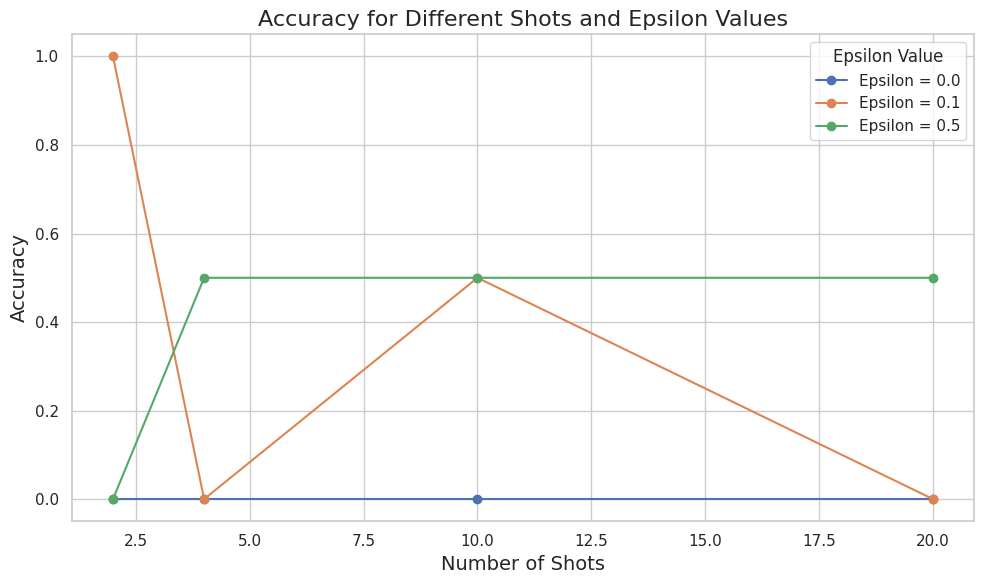

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))

# Use seaborn style for better appearance
sns.set(style="whitegrid")

# Plot accuracy for different epsilon values
for epsilon in epsilon_list:
    epsilon_results = results_df[results_df['Epsilon'] == epsilon]
    plt.plot(epsilon_results['Shots'], epsilon_results['Accuracy'], label=f"Epsilon = {epsilon}", marker='o')

# Add labels and title
plt.title("Accuracy for Different Shots and Epsilon Values", fontsize=16)
plt.xlabel("Number of Shots", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Add a legend
plt.legend(title="Epsilon Value", loc="best")

# Display the plot
plt.tight_layout()
plt.show()

###Swaranjali Code

<ipython-input-12-f038c2e08c96>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]


Generated synthetic data with epsilon=0.1.


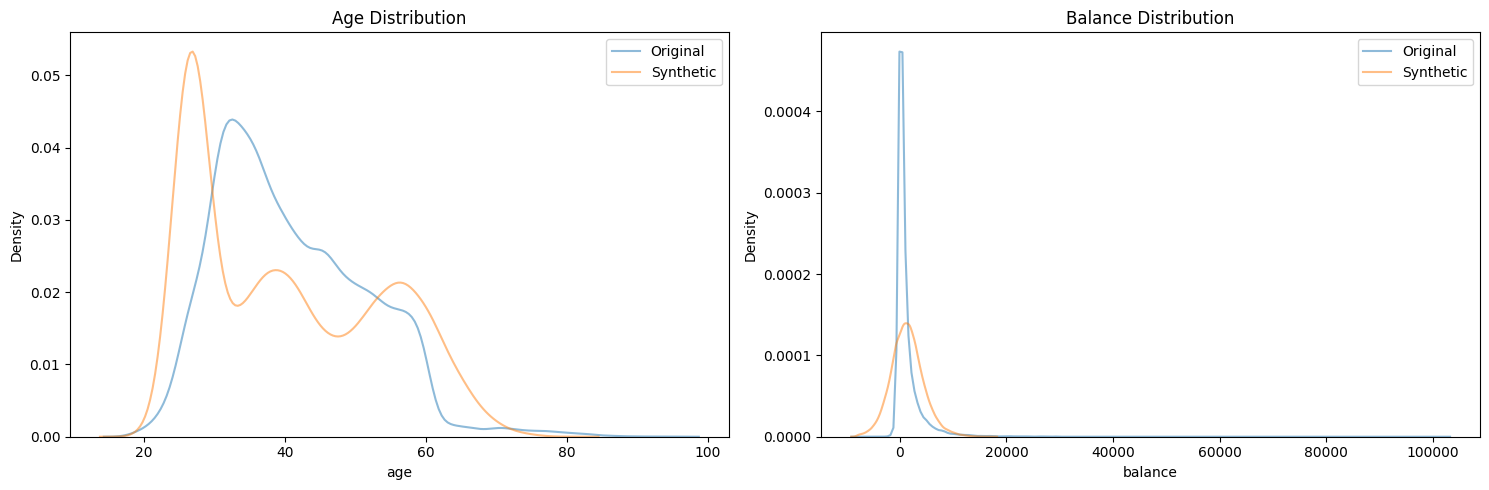

<ipython-input-12-f038c2e08c96>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]


Generated synthetic data with epsilon=0.5.


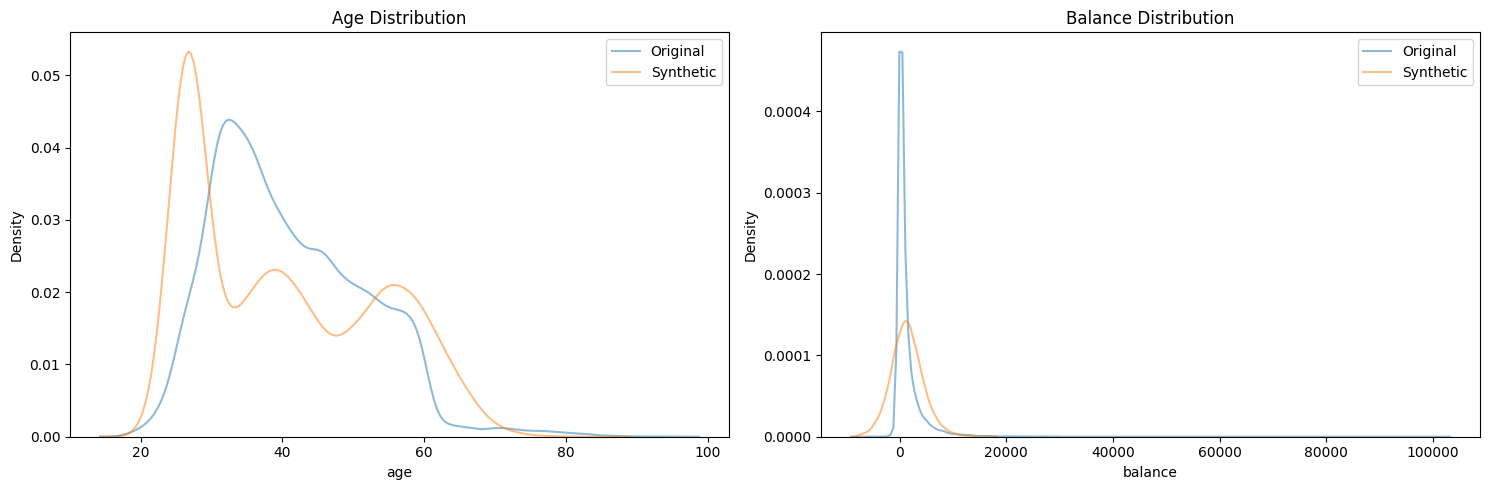

<ipython-input-12-f038c2e08c96>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]


Generated synthetic data with epsilon=1.0.


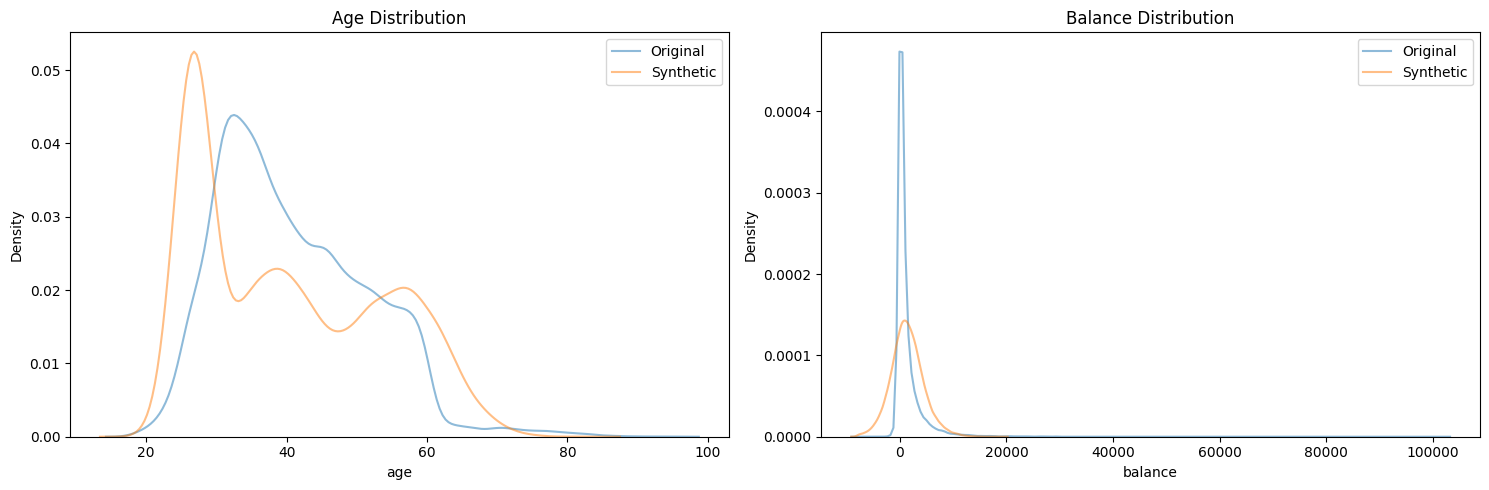

<ipython-input-12-f038c2e08c96>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]


Generated synthetic data with epsilon=2.0.


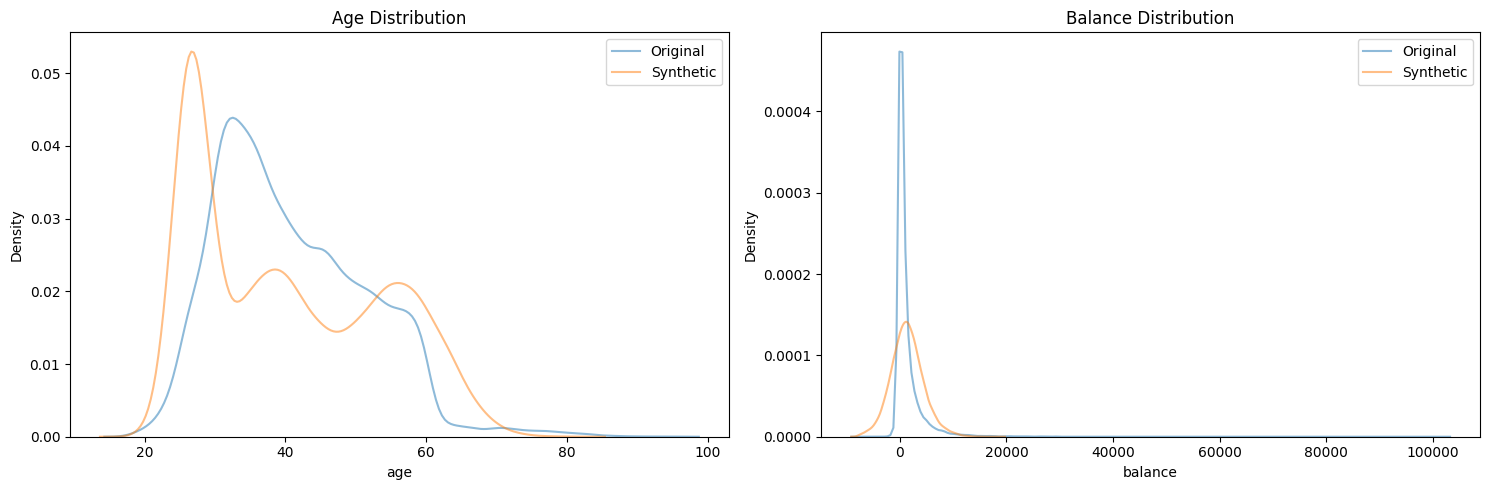

Insufficient privacy budget for synthetic data generation


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from typing import Dict, List, Optional
from collections import defaultdict
import seaborn as sns
from scipy.stats import truncnorm

class PrivacyBudgetManager:
    """Manages privacy budget allocation for synthetic data generation."""

    def __init__(self, total_budget: float):
        self.total_budget = total_budget
        self.spent_budget = defaultdict(float)
        self.operation_history = []

    def request_budget(self, operation: str, amount: float) -> bool:
        """Request privacy budget for an operation."""
        if self.get_remaining_budget() < amount:
            return False

        self.spent_budget[operation] += amount
        self.operation_history.append({
            'operation': operation,
            'amount': amount,
            'remaining': self.get_remaining_budget()
        })
        return True

    def get_remaining_budget(self) -> float:
        """Get remaining privacy budget."""
        return self.total_budget - sum(self.spent_budget.values())

    def generate_report(self) -> Dict:
        """Generate privacy budget usage report."""
        return {
            'total_budget': self.total_budget,
            'spent_budget': dict(self.spent_budget),
            'remaining_budget': self.get_remaining_budget(),
            'operation_history': self.operation_history
        }

class SyntheticDataGenerator:
    """Generates synthetic data with privacy preservation."""

    def __init__(self, budget_manager: PrivacyBudgetManager):
        self.budget_manager = budget_manager
        self.feature_ranges = {}
        self.generation_params = {}
        self.target_distribution = None

    def analyze_original_data(self, data: pd.DataFrame) -> None:
        """Analyze original data to set generation parameters."""
        # Store target distribution for later use
        if 'y' in data.columns:
            self.target_distribution = data['y'].value_counts(normalize=True)
            data['y'] = data['y'].map({'no': 0, 'yes': 1})

        # Calculate feature ranges for numeric columns
        self.feature_ranges = {
            col: {
                'min': data[col].min(),
                'max': data[col].max(),
                'mean': data[col].mean(),
                'std': data[col].std()
            }
            for col in data.columns if col != 'y'
        }

        # Store additional parameters for procedural generation
        self.generation_params = {
            'age_clusters': self._identify_age_clusters(data),
            'balance_patterns': self._analyze_balance_patterns(data)
        }

    def _identify_age_clusters(self, data: pd.DataFrame) -> Dict:
        """Identify age clusters in the data."""
        age_data = data['age']
        return {
            'young': {'mean': age_data[age_data < 30].mean(), 'std': max(age_data[age_data < 30].std(), 1)},
            'middle': {'mean': age_data[(age_data >= 30) & (age_data < 50)].mean(),
                       'std': max(age_data[(age_data >= 30) & (age_data < 50)].std(), 1)},
            'senior': {'mean': age_data[age_data >= 50].mean(),
                       'std': max(age_data[age_data >= 50].std(), 1)}
        }

    def _analyze_balance_patterns(self, data: pd.DataFrame) -> Dict:
        """Analyze balance patterns in different age groups."""
        return {
            'young': {'mean': data[data['age'] < 30]['balance'].mean(),
                      'std': max(data[data['age'] < 30]['balance'].std(), 1)},
            'middle': {'mean': data[(data['age'] >= 30) & (data['age'] < 50)]['balance'].mean(),
                       'std': max(data[(data['age'] >= 30) & (data['age'] < 50)]['balance'].std(), 1)},
            'senior': {'mean': data[data['age'] >= 50]['balance'].mean(),
                       'std': max(data[data['age'] >= 50]['balance'].std(), 1)}
        }

    def generate_synthetic_sample(self, n_samples: int, epsilon: float) -> pd.DataFrame:
        """Generate synthetic data samples with privacy preservation."""
        if not self.budget_manager.request_budget('synthetic_generation', epsilon):
            raise ValueError("Insufficient privacy budget for synthetic data generation")

        synthetic_data = {}

        # Generate age values using procedural generation
        age_cluster = np.random.choice(['young', 'middle', 'senior'], n_samples)
        age_values = []
        for cluster in age_cluster:
            params = self.generation_params['age_clusters'][cluster]
            age = truncnorm.rvs(
                (self.feature_ranges['age']['min'] - params['mean']) / params['std'],
                (self.feature_ranges['age']['max'] - params['mean']) / params['std'],
                loc=params['mean'],
                scale=params['std']
            )
            age_values.append(age)

        synthetic_data['age'] = np.array(age_values)

        # Generate correlated balance values
        balance_values = []
        for cluster in age_cluster:
            params = self.generation_params['balance_patterns'][cluster]
            base_balance = truncnorm.rvs(
                (self.feature_ranges['balance']['min'] - params['mean']) / params['std'],
                (self.feature_ranges['balance']['max'] - params['mean']) / params['std'],
                loc=params['mean'],
                scale=params['std']
            )
            noise = np.random.laplace(0, 1/epsilon)
            balance_values.append(base_balance + noise)

        synthetic_data['balance'] = np.array(balance_values)

        # Generate target variable if distribution is available
        if self.target_distribution is not None:
            synthetic_data['y'] = np.random.choice(
                ['no', 'yes'],
                size=n_samples,
                p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]
            )

        return pd.DataFrame(synthetic_data)

    def plot_synthetic_comparison(self, original_data: pd.DataFrame,
                                  synthetic_data: pd.DataFrame) -> None:
        """Plot comparison between original and synthetic data."""
        plt.figure(figsize=(15, 5))

        # Age distribution
        plt.subplot(1, 2, 1)
        sns.kdeplot(data=original_data, x='age', label='Original', alpha=0.5)
        sns.kdeplot(data=synthetic_data, x='age', label='Synthetic', alpha=0.5)
        plt.title('Age Distribution')
        plt.legend()

        # Balance distribution
        plt.subplot(1, 2, 2)
        sns.kdeplot(data=original_data, x='balance', label='Original', alpha=0.5)
        sns.kdeplot(data=synthetic_data, x='balance', label='Synthetic', alpha=0.5)
        plt.title('Balance Distribution')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Main script
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('bank.csv', delimiter=';')[['age', 'balance', 'y']]

    # Initialize privacy budget manager and generator
    budget_manager = PrivacyBudgetManager(total_budget=5.0)
    generator = SyntheticDataGenerator(budget_manager)

    # Analyze original data
    generator.analyze_original_data(data)

    # Generate synthetic data for different epsilon values
    epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0]
    for epsilon in epsilon_values:
        try:
            synthetic_data = generator.generate_synthetic_sample(len(data), epsilon)
            print(f"Generated synthetic data with epsilon={epsilon}.")

            # Plot comparison
            generator.plot_synthetic_comparison(data, synthetic_data)
        except ValueError as e:
            print(e)



##The trade-off between privacy and utility is determined by balancing the impact of epsilon (privacy level) and model accuracy, using a dynamic lambda. lambda that adjusts based on their respective ranges. Lambda is calculated as the ratio of epsilon's range to accuracy's range, ensuring fair weighting without hardcoding. The score for each epsilon is computed as  {Accuracy} - (lambda {Epsilon}) , where higher accuracy is rewarded, and larger epsilon is penalized. The optimal epsilon maximizes this score, representing the best balance between preserving data privacy and maintaining model utility, dynamically adapting to dataset characteristics.


Dynamic Lambda: 0.4900
Optimal Epsilon: 0.1
Corresponding Accuracy: 70.00%

Trade-Off Analysis:
The selected epsilon dynamically balances accuracy and privacy by optimizing the trade-off score.


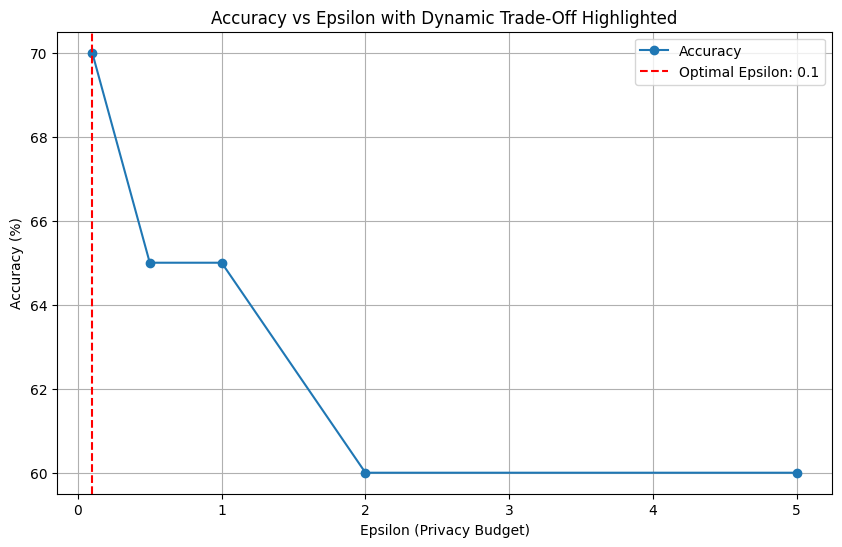

In [ ]:
# Function to dynamically calculate lambda
def calculate_dynamic_lambda(results: pd.DataFrame) -> float:
    """Calculate lambda dynamically based on the ranges of epsilon and accuracy."""
    epsilon_range = results['epsilon'].max() - results['epsilon'].min()
    accuracy_range = results['accuracy'].max() - results['accuracy'].min()

    if accuracy_range == 0:  # Avoid division by zero
        raise ValueError("Accuracy range is zero; cannot calculate dynamic lambda.")

    return epsilon_range / accuracy_range

# Function to calculate trade-off score
def calculate_tradeoff_score(results: pd.DataFrame, lambda_: Optional[float] = None) -> Tuple[float, float]:
    """Calculate the trade-off score between accuracy and epsilon."""
    if lambda_ is None:
        lambda_ = calculate_dynamic_lambda(results)

    results['score'] = results['accuracy'] - lambda_ * results['epsilon']
    optimal_index = results['score'].idxmax()
    optimal_epsilon = results.loc[optimal_index, 'epsilon']
    optimal_accuracy = results.loc[optimal_index, 'accuracy']
    return optimal_epsilon, optimal_accuracy, lambda_

# Initialize the results DataFrame
results_df = pd.DataFrame(results)  # Assuming `results` is a list of {'epsilon': ..., 'accuracy': ...}

# Determine the most optimal epsilon
optimal_epsilon, optimal_accuracy, lambda_tradeoff = calculate_tradeoff_score(results_df)

# Print the results
print(f"\nDynamic Lambda: {lambda_tradeoff:.4f}")
print(f"Optimal Epsilon: {optimal_epsilon}")
print(f"Corresponding Accuracy: {optimal_accuracy:.2f}%")
print("\nTrade-Off Analysis:")
print("The selected epsilon dynamically balances accuracy and privacy by optimizing the trade-off score.")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['epsilon'], results_df['accuracy'], marker='o', label='Accuracy')
plt.axvline(optimal_epsilon, color='red', linestyle='--', label=f'Optimal Epsilon: {optimal_epsilon}')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epsilon with Dynamic Trade-Off Highlighted')
plt.legend()
plt.grid()
plt.show()


<ipython-input-16-5846ebb51bf1>:173: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]


Generated synthetic data with epsilon=0.1.


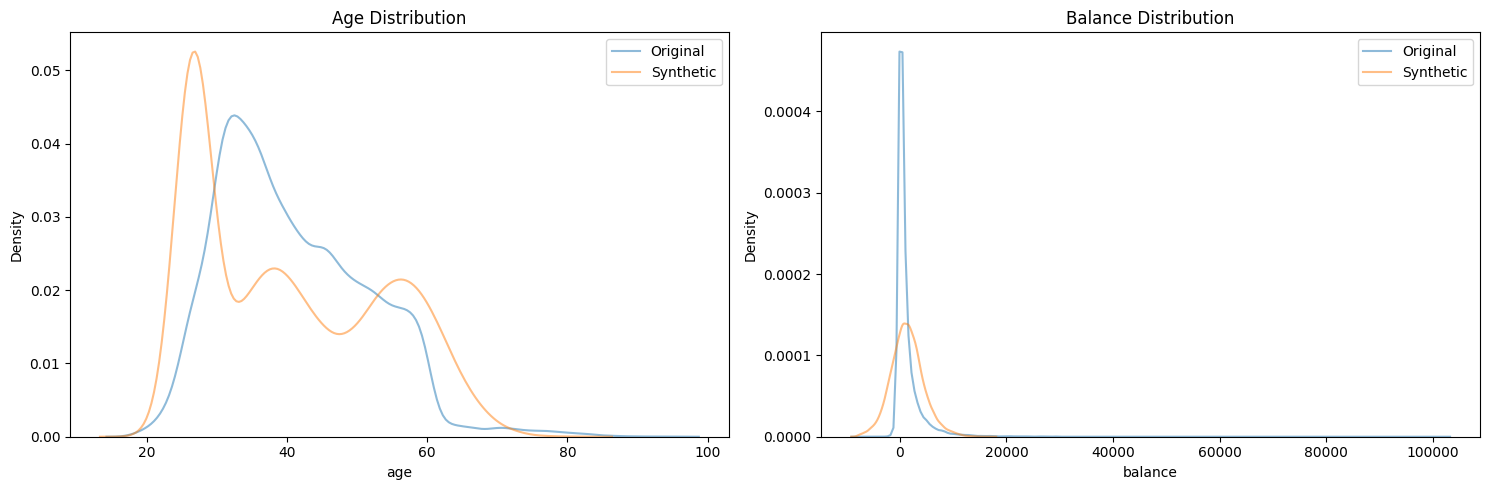

<ipython-input-16-5846ebb51bf1>:173: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]


Generated synthetic data with epsilon=0.5.


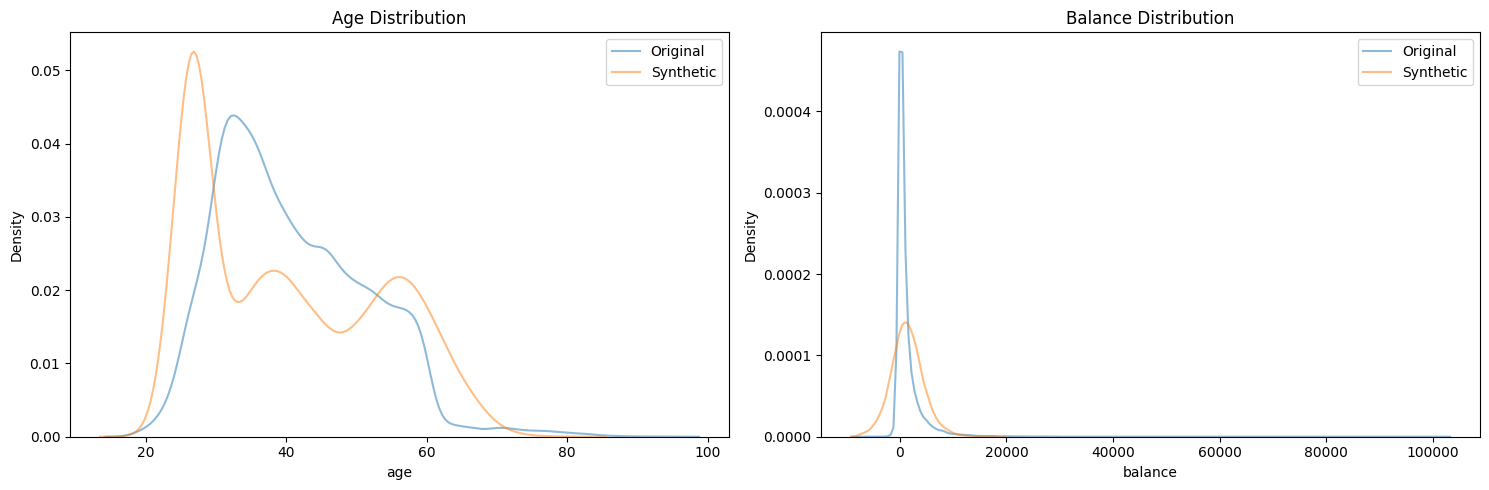

<ipython-input-16-5846ebb51bf1>:173: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]


Generated synthetic data with epsilon=1.0.


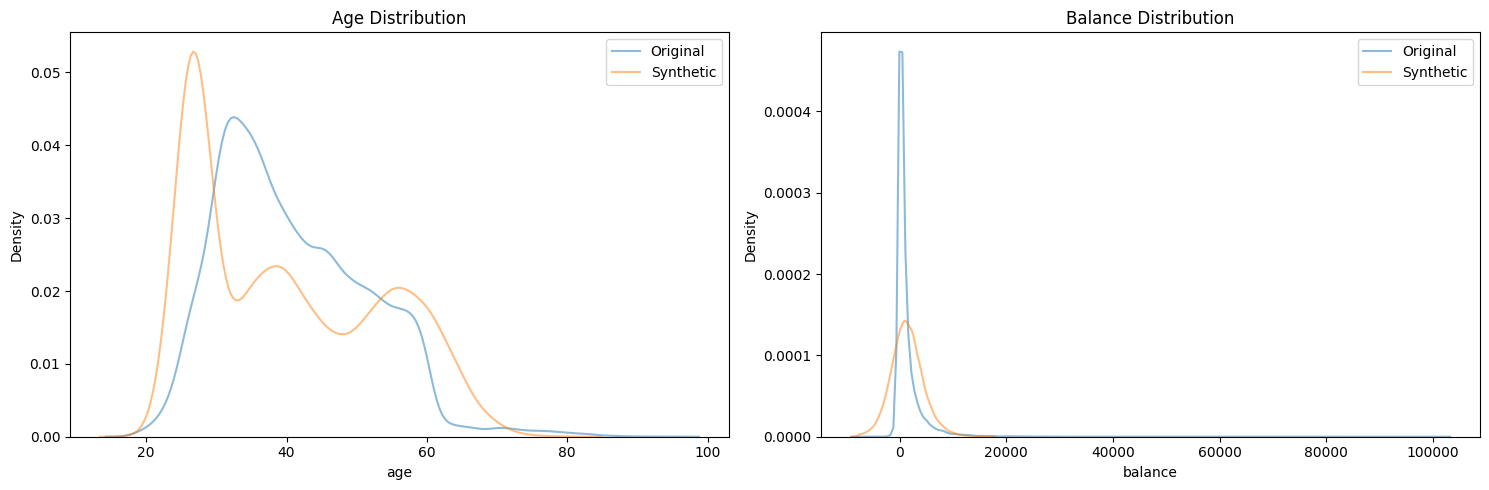

<ipython-input-16-5846ebb51bf1>:173: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]


Generated synthetic data with epsilon=2.0.


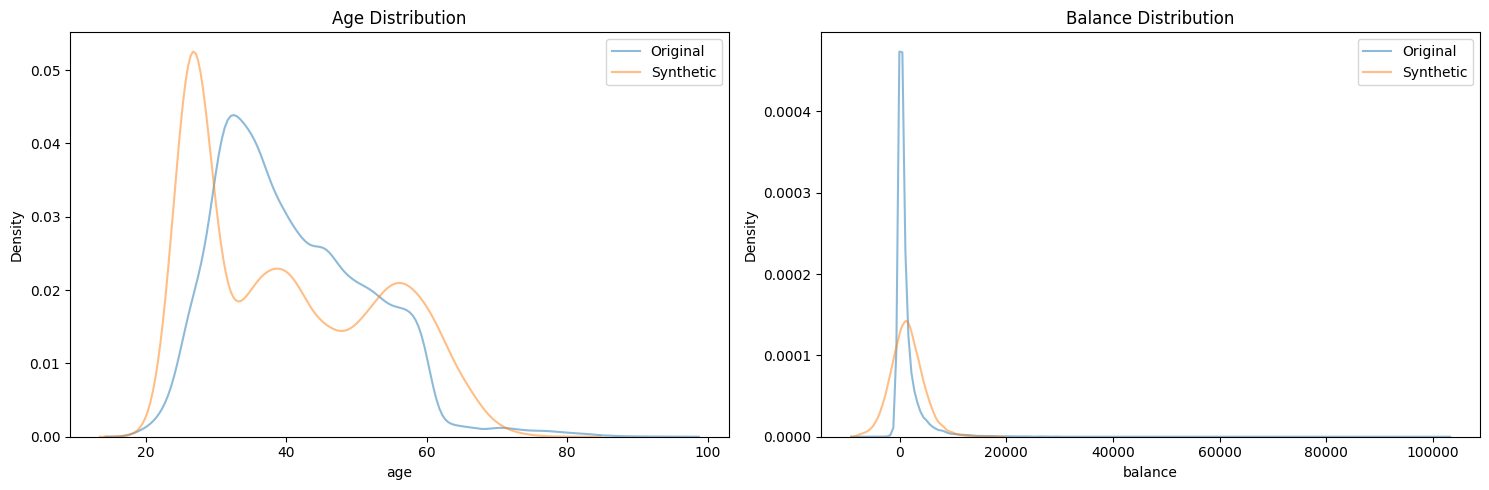

Insufficient privacy budget for synthetic data generation

Audit Log Report:
--------------------------------------------------
2024-11-16 23:21:14 | Operation: synthetic_generation | Amount: 0.1 | Remaining Budget: 4.9 | Status: Approved
2024-11-16 23:21:32 | Operation: synthetic_generation | Amount: 0.5 | Remaining Budget: 4.4 | Status: Approved
2024-11-16 23:21:49 | Operation: synthetic_generation | Amount: 1.0 | Remaining Budget: 3.4 | Status: Approved
2024-11-16 23:22:08 | Operation: synthetic_generation | Amount: 2.0 | Remaining Budget: 1.4 | Status: Approved
2024-11-16 23:22:25 | Operation: synthetic_generation | Amount: 5.0 | Remaining Budget: 1.4 | Status: Denied



In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from typing import Dict, List, Optional
from collections import defaultdict
import seaborn as sns
from scipy.stats import truncnorm

class AuditLog:
    """Handles logging of privacy-related events for transparency."""

    def __init__(self):
        self.logs = []

    def log_event(self, operation: str, amount: float, remaining_budget: float, status: str):
        """Log an event in the audit log."""
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        self.logs.append({
            'timestamp': timestamp,
            'operation': operation,
            'amount': amount,
            'remaining_budget': remaining_budget,
            'status': status
        })

    def generate_report(self):
        """Generate a formatted audit report."""
        report = "\nAudit Log Report:\n"
        report += "-"*50 + "\n"
        for log in self.logs:
            report += f"{log['timestamp']} | Operation: {log['operation']} | Amount: {log['amount']} | Remaining Budget: {log['remaining_budget']} | Status: {log['status']}\n"
        return report

class PrivacyBudgetManager:
    """Manages privacy budget allocation for synthetic data generation."""

    def __init__(self, total_budget: float, audit_log: AuditLog):
        self.total_budget = total_budget
        self.spent_budget = defaultdict(float)
        self.operation_history = []
        self.audit_log = audit_log

    def request_budget(self, operation: str, amount: float) -> bool:
        """Request privacy budget for an operation."""
        if self.get_remaining_budget() < amount:
            status = 'Denied'
            self.audit_log.log_event(operation, amount, self.get_remaining_budget(), status)
            return False

        self.spent_budget[operation] += amount
        self.operation_history.append({
            'operation': operation,
            'amount': amount,
            'remaining': self.get_remaining_budget()
        })

        status = 'Approved'
        self.audit_log.log_event(operation, amount, self.get_remaining_budget(), status)
        return True

    def get_remaining_budget(self) -> float:
        """Get remaining privacy budget."""
        return self.total_budget - sum(self.spent_budget.values())

    def generate_report(self) -> Dict:
        """Generate privacy budget usage report."""
        return {
            'total_budget': self.total_budget,
            'spent_budget': dict(self.spent_budget),
            'remaining_budget': self.get_remaining_budget(),
            'operation_history': self.operation_history
        }

class SyntheticDataGenerator:
    """Generates synthetic data with privacy preservation."""

    def __init__(self, budget_manager: PrivacyBudgetManager):
        self.budget_manager = budget_manager
        self.feature_ranges = {}
        self.generation_params = {}
        self.target_distribution = None

    def analyze_original_data(self, data: pd.DataFrame) -> None:
        """Analyze original data to set generation parameters."""
        # Store target distribution for later use
        if 'y' in data.columns:
            self.target_distribution = data['y'].value_counts(normalize=True)
            data['y'] = data['y'].map({'no': 0, 'yes': 1})

        # Calculate feature ranges for numeric columns
        self.feature_ranges = {
            col: {
                'min': data[col].min(),
                'max': data[col].max(),
                'mean': data[col].mean(),
                'std': data[col].std()
            }
            for col in data.columns if col != 'y'
        }

        # Store additional parameters for procedural generation
        self.generation_params = {
            'age_clusters': self._identify_age_clusters(data),
            'balance_patterns': self._analyze_balance_patterns(data)
        }

    def _identify_age_clusters(self, data: pd.DataFrame) -> Dict:
        """Identify age clusters in the data."""
        age_data = data['age']
        return {
            'young': {'mean': age_data[age_data < 30].mean(), 'std': max(age_data[age_data < 30].std(), 1)},
            'middle': {'mean': age_data[(age_data >= 30) & (age_data < 50)].mean(),
                       'std': max(age_data[(age_data >= 30) & (age_data < 50)].std(), 1)},
            'senior': {'mean': age_data[age_data >= 50].mean(),
                       'std': max(age_data[age_data >= 50].std(), 1)}
        }

    def _analyze_balance_patterns(self, data: pd.DataFrame) -> Dict:
        """Analyze balance patterns in different age groups."""
        return {
            'young': {'mean': data[data['age'] < 30]['balance'].mean(),
                      'std': max(data[data['age'] < 30]['balance'].std(), 1)},
            'middle': {'mean': data[(data['age'] >= 30) & (data['age'] < 50)]['balance'].mean(),
                       'std': max(data[(data['age'] >= 30) & (data['age'] < 50)]['balance'].std(), 1)},
            'senior': {'mean': data[data['age'] >= 50]['balance'].mean(),
                       'std': max(data[data['age'] >= 50]['balance'].std(), 1)}
        }

    def generate_synthetic_sample(self, n_samples: int, epsilon: float) -> pd.DataFrame:
        """Generate synthetic data samples with privacy preservation."""
        if not self.budget_manager.request_budget('synthetic_generation', epsilon):
            raise ValueError("Insufficient privacy budget for synthetic data generation")

        synthetic_data = {}

        # Generate age values using procedural generation
        age_cluster = np.random.choice(['young', 'middle', 'senior'], n_samples)
        age_values = []
        for cluster in age_cluster:
            params = self.generation_params['age_clusters'][cluster]
            age = truncnorm.rvs(
                (self.feature_ranges['age']['min'] - params['mean']) / params['std'],
                (self.feature_ranges['age']['max'] - params['mean']) / params['std'],
                loc=params['mean'],
                scale=params['std']
            )
            age_values.append(age)

        synthetic_data['age'] = np.array(age_values)

        # Generate correlated balance values
        balance_values = []
        for cluster in age_cluster:
            params = self.generation_params['balance_patterns'][cluster]
            base_balance = truncnorm.rvs(
                (self.feature_ranges['balance']['min'] - params['mean']) / params['std'],
                (self.feature_ranges['balance']['max'] - params['mean']) / params['std'],
                loc=params['mean'],
                scale=params['std']
            )
            noise = np.random.laplace(0, 1/epsilon)
            balance_values.append(base_balance + noise)

        synthetic_data['balance'] = np.array(balance_values)

        # Generate target variable if distribution is available
        if self.target_distribution is not None:
            synthetic_data['y'] = np.random.choice(
                ['no', 'yes'],
                size=n_samples,
                p=[self.target_distribution.get(0, 0.5), self.target_distribution.get(1, 0.5)]
            )

        return pd.DataFrame(synthetic_data)

    def plot_synthetic_comparison(self, original_data: pd.DataFrame,
                                  synthetic_data: pd.DataFrame) -> None:
        """Plot comparison between original and synthetic data."""
        plt.figure(figsize=(15, 5))

        # Age distribution
        plt.subplot(1, 2, 1)
        sns.kdeplot(data=original_data, x='age', label='Original', alpha=0.5)
        sns.kdeplot(data=synthetic_data, x='age', label='Synthetic', alpha=0.5)
        plt.title('Age Distribution')
        plt.legend()

        # Balance distribution
        plt.subplot(1, 2, 2)
        sns.kdeplot(data=original_data, x='balance', label='Original', alpha=0.5)
        sns.kdeplot(data=synthetic_data, x='balance', label='Synthetic', alpha=0.5)
        plt.title('Balance Distribution')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Main script
if __name__ == "__main__":
    # Create an instance of the audit log
    audit_log = AuditLog()

    # Load data
    data = pd.read_csv('bank.csv', delimiter=';')[['age', 'balance', 'y']]

    # Initialize privacy budget manager with the audit log
    budget_manager = PrivacyBudgetManager(total_budget=5.0, audit_log=audit_log)
    generator = SyntheticDataGenerator(budget_manager)

    # Analyze original data
    generator.analyze_original_data(data)

    # Generate synthetic data for different epsilon values
    epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0]
    for epsilon in epsilon_values:
        try:
            synthetic_data = generator.generate_synthetic_sample(len(data), epsilon)
            print(f"Generated synthetic data with epsilon={epsilon}.")

            # Plot comparison
            generator.plot_synthetic_comparison(data, synthetic_data)
        except ValueError as e:
            print(e)

    # Generate audit log report
    print(audit_log.generate_report())


In [ ]:
import pandas as pd
import numpy as np

# Load data with semicolon delimiter
data = pd.read_csv('bank.csv', delimiter=';')

# Define attribute sensitivity (manually or based on domain knowledge)
sensitive_attributes = {
    'highly_sensitive': ['age', 'balance', 'loan', 'default']
}

# Function to assess sensitivity of attributes (dynamic analysis)
def assess_sensitivity(data: pd.DataFrame, sensitive_attributes: dict):
    sensitivity_scores = {}

    for category, attributes in sensitive_attributes.items():
        for attribute in attributes:
            if attribute in data.columns:
                # Check the column type and handle accordingly
                if data[attribute].dtype == 'object':  # Categorical features
                    sensitivity_scores[attribute] = 'Moderate'  # Less sensitive generally
                else:  # Numerical features
                    # Remove missing values before calculating variance
                    column_data = data[attribute].dropna()

                    # Ensure the column is numeric before calculating variance
                    if pd.api.types.is_numeric_dtype(column_data):
                        variance = column_data.var()
                        if variance > 1000:  # Arbitrary threshold for variance
                            sensitivity_scores[attribute] = 'High'
                        elif variance > 100:  # Lower threshold for variance
                            sensitivity_scores[attribute] = 'Moderate'
                        else:
                            sensitivity_scores[attribute] = 'Low'
                    else:
                        # If the column is not numeric, treat it as less sensitive
                        sensitivity_scores[attribute] = 'Moderate'

    return sensitivity_scores

# Function to add noise to the highly sensitive data (controlled Laplace noise)
def add_laplace_noise(data: pd.DataFrame, attributes: list, epsilon: float):
    noisy_data = data.copy()

    for attribute in attributes:
        if attribute in data.columns:
            # Add Laplace noise only to numeric attributes
            if pd.api.types.is_numeric_dtype(data[attribute]):
                # Determine scale for Laplace noise based on the attribute's standard deviation
                scale = data[attribute].std() / epsilon

                # Generate Laplace noise
                noise = np.random.laplace(0, scale, size=data[attribute].shape)

                # Add noise to the original data
                noisy_data[attribute] = data[attribute] + noise

                # Clip values for balance and other attributes to keep them realistic
                if attribute == 'balance':
                    noisy_data[attribute] = np.clip(noisy_data[attribute], 0, data[attribute].max())

                if attribute == 'age':
                    noisy_data[attribute] = np.clip(noisy_data[attribute], 18, 100)  # Age should be realistic

    return noisy_data

# Epsilon (privacy budget) for noise addition
epsilon = 2  # Adjust epsilon for better balance between privacy and accuracy

# Get highly sensitive attributes from both manual and dynamic analysis
sensitivity_scores = assess_sensitivity(data, sensitive_attributes)
highly_sensitive_attributes = sensitive_attributes['highly_sensitive']

# Generate noisy data for highly sensitive attributes
noisy_data = add_laplace_noise(data, highly_sensitive_attributes, epsilon)

# Show the original and noisy data for highly sensitive attributes
print("\nOriginal Data (selected highly sensitive attributes):")
print(data[highly_sensitive_attributes].head())  # Show first few rows of original data for sensitive attributes

print("\nNoisy Data (with Laplace noise added to highly sensitive attributes):")
print(noisy_data[highly_sensitive_attributes].head())  # Show first few rows of noisy data for sensitive attributes



Original Data (selected highly sensitive attributes):
   age  balance loan default
0   58     2143   no      no
1   44       29   no      no
2   33        2  yes      no
3   47     1506   no      no
4   33        1   no      no

Noisy Data (with Laplace noise added to highly sensitive attributes):
         age      balance loan default
0  63.695606  1862.507677   no      no
1  38.630752   273.963863   no      no
2  31.943837  3370.446246  yes      no
3  42.775570     0.000000   no      no
4  41.675490     0.000000   no      no


In [ ]:
# Print all highly sensitive attributes
print("\nHighly Sensitive Attributes:")
print(highly_sensitive_attributes)

# Print sensitivity scores for all attributes (from dynamic analysis)
print("\nSensitivity Scores for All Attributes:")
for attribute, score in sensitivity_scores.items():
    print(f"{attribute}: {score}")



Highly Sensitive Attributes:
['age', 'balance', 'loan', 'default']

Sensitivity Scores for All Attributes:
age: Moderate
balance: High
loan: Moderate
default: Moderate


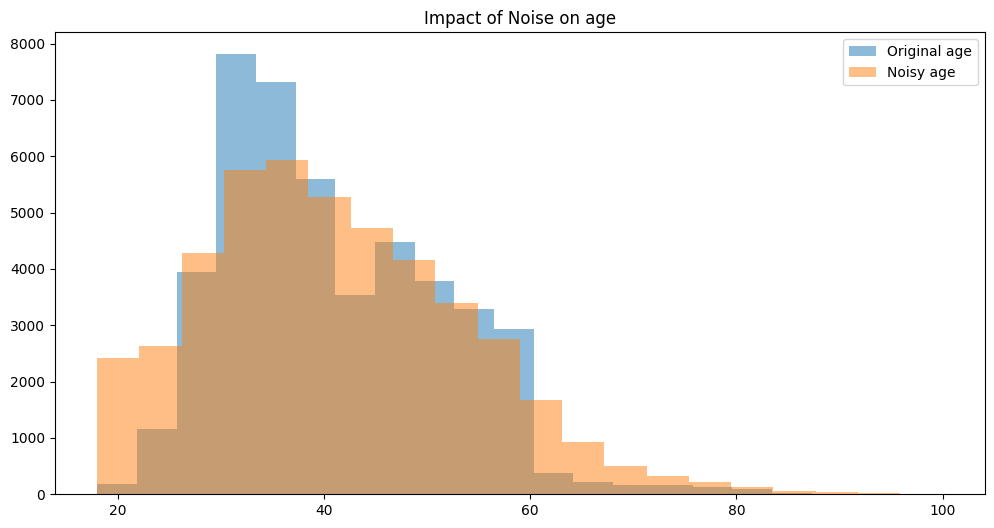

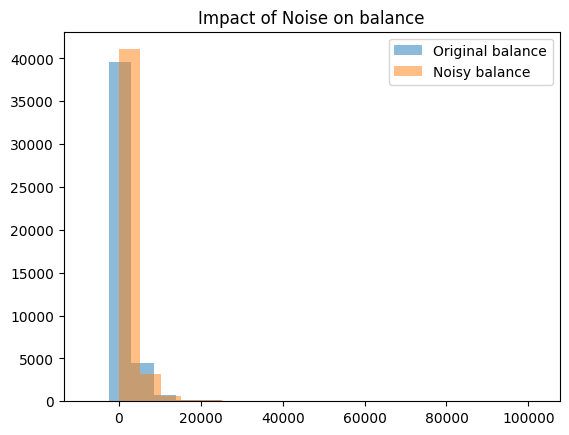

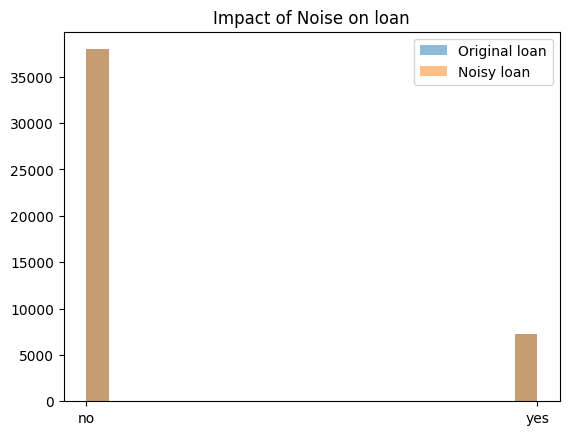

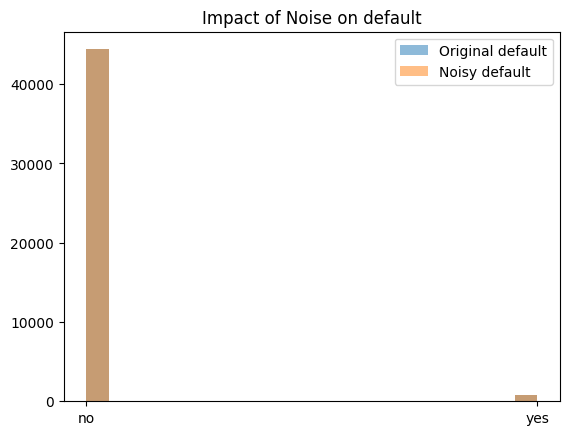

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for attribute in highly_sensitive_attributes:
    plt.hist(data[attribute], bins=20, alpha=0.5, label=f"Original {attribute}")
    plt.hist(noisy_data[attribute], bins=20, alpha=0.5, label=f"Noisy {attribute}")
    plt.title(f"Impact of Noise on {attribute}")
    plt.legend()
    plt.show()


In [ ]:
for attr in highly_sensitive_attributes:
    original_var = data[attr].var()
    noise_var = (data[attr] - noisy_data[attr]).var()
    nsr = noise_var / original_var
    print(f"NSR for {attr}: {nsr:.4f}")


NSR for age: 0.4544
NSR for balance: 0.2635


TypeError: could not convert string to float: 'no'

In [ ]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Attribute Correlation Matrix")
plt.show()

# Identify attributes highly correlated with sensitive features
for attr in highly_sensitive_attributes:
    correlated_attrs = correlation_matrix[attr][correlation_matrix[attr].abs() > 0.5]
    print(f"Attributes correlated with {attr}:")
    print(correlated_attrs)



ValueError: could not convert string to float: 'management'

In [ ]:
summary_report = pd.DataFrame({
    "Attribute": highly_sensitive_attributes,
    "Original Mean": [
        data[attr].mean() if pd.api.types.is_numeric_dtype(data[attr]) else "N/A"
        for attr in highly_sensitive_attributes
    ],
    "Noisy Mean": [
        noisy_data[attr].mean() if pd.api.types.is_numeric_dtype(noisy_data[attr]) else "N/A"
        for attr in highly_sensitive_attributes
    ],
    "Original Std Dev": [
        data[attr].std() if pd.api.types.is_numeric_dtype(data[attr]) else "N/A"
        for attr in highly_sensitive_attributes
    ],
    "Noisy Std Dev": [
        noisy_data[attr].std() if pd.api.types.is_numeric_dtype(noisy_data[attr]) else "N/A"
        for attr in highly_sensitive_attributes
    ],
})
print(summary_report)



  Attribute Original Mean   Noisy Mean Original Std Dev Noisy Std Dev
0       age      40.93621    41.021174        10.618762     12.727975
1   balance   1362.272058  1860.090812      3044.765829   3278.600802
2      loan           N/A          N/A              N/A           N/A
3   default           N/A          N/A              N/A           N/A


  Attribute  Original Mean   Noisy Mean  Original Std Dev  Noisy Std Dev  \
0       age      40.936210    41.021174         10.618762      12.727975   
1   balance    1362.272058  1860.090812       3044.765829    3278.600802   

   Original Variance  Noisy Variance  Original Outliers  Noisy Outliers  
0       1.127581e+02    1.620014e+02                381             261  
1       9.270599e+06    1.074922e+07                745             701  


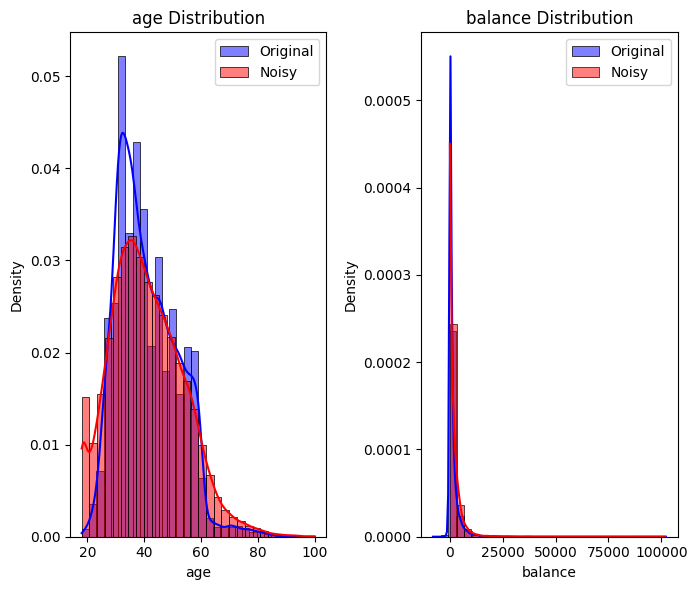

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Detailed analysis report for both original and noisy data
detailed_report = []

for attribute in highly_sensitive_attributes:
    if attribute in data.columns:
        if pd.api.types.is_numeric_dtype(data[attribute]):
            original_mean = data[attribute].mean()
            noisy_mean = noisy_data[attribute].mean()
            original_std = data[attribute].std()
            noisy_std = noisy_data[attribute].std()
            original_var = data[attribute].var()
            noisy_var = noisy_data[attribute].var()

            # Outlier detection using Z-score method (threshold > 3 indicates an outlier)
            z_scores_original = stats.zscore(data[attribute].dropna())
            z_scores_noisy = stats.zscore(noisy_data[attribute].dropna())
            outliers_original = sum(abs(z_scores_original) > 3)
            outliers_noisy = sum(abs(z_scores_noisy) > 3)

            # Collecting detailed results
            detailed_report.append({
                'Attribute': attribute,
                'Original Mean': original_mean,
                'Noisy Mean': noisy_mean,
                'Original Std Dev': original_std,
                'Noisy Std Dev': noisy_std,
                'Original Variance': original_var,
                'Noisy Variance': noisy_var,
                'Original Outliers': outliers_original,
                'Noisy Outliers': outliers_noisy,
            })

# Convert to DataFrame for better visualization
detailed_report_df = pd.DataFrame(detailed_report)

# Displaying detailed report
print(detailed_report_df)

# Visualizing the distributions of original and noisy data
plt.figure(figsize=(14, 6))
for i, attribute in enumerate(highly_sensitive_attributes, 1):
    if attribute in data.columns:
        if pd.api.types.is_numeric_dtype(data[attribute]):
            plt.subplot(1, len(highly_sensitive_attributes), i)
            sns.histplot(data[attribute], color='blue', kde=True, stat='density', label='Original', bins=30)
            sns.histplot(noisy_data[attribute], color='red', kde=True, stat='density', label='Noisy', bins=30)
            plt.title(f'{attribute} Distribution')
            plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Number of columns
num_columns = detailed_report_df.shape[1]

# Print columns in batches of 2 with a gap after each pair
for i in range(0, num_columns, 2):
    print(detailed_report_df.iloc[:, i:i+2])
    print()  # Add a gap after each pair of columns




  Attribute  Original Mean
0       age      40.936210
1   balance    1362.272058

    Noisy Mean  Original Std Dev
0    41.021174         10.618762
1  1860.090812       3044.765829

   Noisy Std Dev  Original Variance
0      12.727975       1.127581e+02
1    3278.600802       9.270599e+06

   Noisy Variance  Original Outliers
0    1.620014e+02                381
1    1.074922e+07                745

   Noisy Outliers
0             261
1             701

